In [1]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.hfreq as hf

# dev
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%reload_ext autoreload
%autoreload 1
#%aimport sstats
%aimport sstats

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=2)
#
client = Client(cluster)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale, base case
dt = 1/24 # hours, sampling interval

# filter properties:
filter_cutoff = [1/5,1/2,1/1.1] # cpd
filter_size = 20 # in days
filter_size_pts = int(20/dt) # in points

print(f"Default filter cutoff frequency and window size: {filter_cutoff}cpd , {filter_size_pts} points = {filter_size} days ")

Default filter cutoff frequency and window size: [0.2, 0.5, 0.9090909090909091]cpd , 480 points = 20 days 


#### Generate lowpass filters with three different cutoff frequency

In [4]:
filter_h, filter_t = {},{}
h_hat, w = {},{}
for filt_cut in filter_cutoff:
    filter_h[str(filt_cut)], filter_t[str(filt_cut)] = sigp.lowpass_filter(filt_cut, filter_size_pts, dt)
    h_hat[str(filt_cut)], w[str(filt_cut)] = sigp.filter_response(filter_h[str(filt_cut)], dt)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


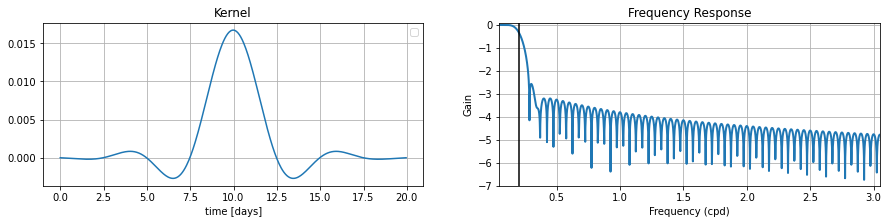

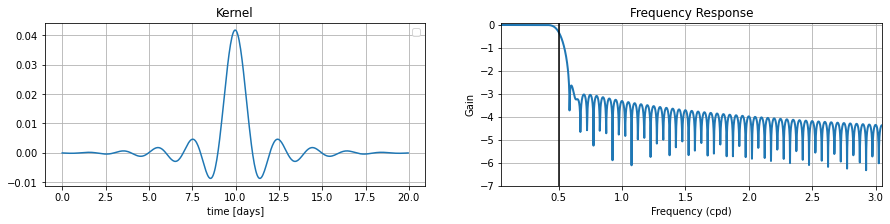

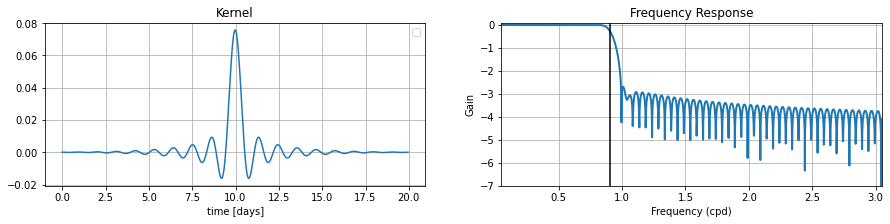

In [5]:
for filt in filter_h.keys():
    fig, axes = plt.subplots(1,2, figsize=(15,3))
    ax = axes[0]
    ax.plot(filter_t[filt], filter_h[filt])
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')
    ax.legend()

    ax = axes[1]
    ax.plot(w[filt], np.log10(abs(h_hat[filt])), linewidth=2)
    ax.axvline(float(filt), color='k')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    #ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(0.05, 3.05)
    ax.grid(True)
#    fig.savefig('/Users/zcaspar/Documents/Figures_methodo/lpass_filt_%s.pdf'%str(np.around(float(filt),decimals=2)))

#### Generate time series and filtered time series

In [6]:
def generate_timeseries(delta_T, n_draws, T, filt, chunks=dict(T=-1)):
    u = mu + ts.exp_autocorr((delta_T, dt), T, 
                             np.sqrt(sigma0), 
                             burnin=int(10*T_all[-1]/dt),
                             draws=n_draws,
                             seed=0,
                             chunks=chunks,
                            )
    ds = u.rename("u").to_dataset()
    # low-pass filter
    ds["u_bar"] = sigp.filt(ds.u, filt)    #filter_h
    return ds

In [7]:
delta_T = 300 # time series length in days
n_draws = 500 # number of draws
T_all = [.1*T, T, 10*T]

ds = xr.concat([generate_timeseries(delta_T, n_draws, T_all, filter_h[k]) for k in filter_h.keys()],
               dim='filt').assign_coords({'filt':np.arange(len(filter_cutoff))})
#N = ds.time.size # = delta_T/dt

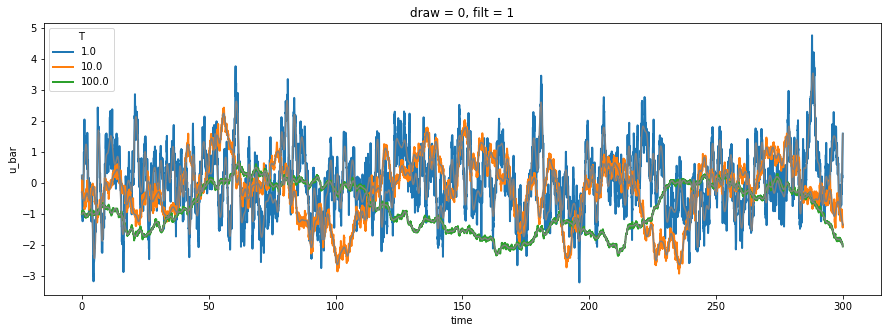

In [15]:
_ds = ds.sel(draw=0, T=[T_all[0], T,  T_all[-1]], filt=1, method="nearest")

fig, ax = plt.subplots(1,1, figsize=(15,5))
_ds.u.plot.line(x="time", lw=2)
_ds.u_bar.plot.line(x="time", color="0.5", add_legend=False)

#### Compute energy 

In [8]:
E = xr.merge( [(ds.u**2).mean("time"), (ds.u_bar**2).mean("time")]).compute()

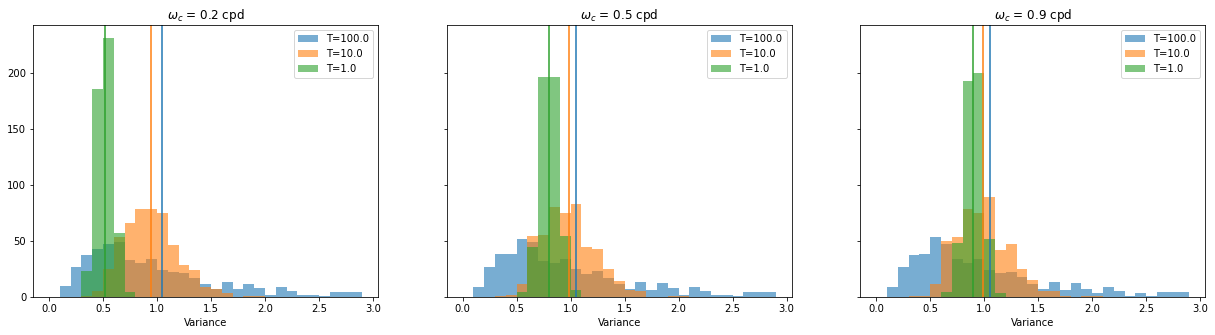

In [16]:
fig, axs = plt.subplots(1,E.filt.size, figsize=(7*E.filt.size,5),sharey=True)
bins = np.arange(0,3,.1)
for ax,j,f in zip(axs,E.filt,filter_h.keys()):
    for _T, i in zip(ds.T[::-1],range(len(ds.T))):
        _da = E["u_bar"].sel(T=_T,filt=j)
        _da.plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
        ax.axvline(_da.mean(), color=f"C{i}")
    ax.legend();ax.set_xlabel('Variance')
    ax.set_title(r'$\omega_c$ = %s cpd'%(np.around(float(f),decimals=1)))

#### Store time series

In [12]:
ds = ds.compute()

In [13]:
ds.to_netcdf('/Users/zcaspar/codes/mit4320/ds_lf.nc')

In [14]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
